Robert é um Investidor Anjo e pretende fechar negócio com algumas startups dos Estados Unidos.<br><br>
Ele pretende fazer uma pesquisa entre 50 startups selecionadas e, para isso, irá precisar de uma análise estatística dessas empresas para tomar sua decisão.<br> <br> 
Você foi contratado por Robert como Consultor de Ciência de Dados para realizar essa análise entre as 50 startups. <br> <br> 
Através de seus conhecimentos de estatística, faça o tratamento de dados necessário da base dessas empresas e monte um modelo de regressão que auxilie na tomada de decisão do investidor.<br> <br> 

# 0 CARREGAMENTO DAS BIBLIOTECAS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import patsy as pt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge

# 1 Ler o arquivo

In [3]:
df = pd.read_csv(r'C:\Users\Rafael Pietro\OneDrive\Cursos\DNC\Datasets\Estatística Avançada\50_Startups.csv')

In [4]:
df.head()
# Gastos de pesquisa e desenvolvimento, gastos de ADM, gastos de Mkt, Estado da Startup e Lucro.

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


# 2 EDA

## 2.1 Estatísticas descritivas

In [6]:
df.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [12]:
df.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

## 2.2 Análise gráfica

### 2.2.1 Nome das colunas

In [15]:
contColNames = list(df.select_dtypes(include=['number']).columns)
contColNames

['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']

### 2.2.2 Cofigurar tamanho do subplot

In [37]:
# Esse número de colunas é a quantidade de colunas de GRÁFICOS que queremos, ou seja, eu quero 4 gráficos separados em 2 colunas.
ncols = 2

In [38]:
# Precisamos de uma formula para que, a partir da quantidade de gráficos que existe e sabendo que existem 3 colunas,
# saber quantas linhas vamos ter nestes gráficos (ou seja, teremos 4 gráficos separados em 2 colunas e 2 linhas).
# Nós fazemos "1.0*ncols" só para garantir que o resultado seja float e funcione no np.ceil.
# O np.ceil serve para arredondar para CIMA o número.
nrows = int(np.ceil(len(contColNames)/(1.0 * ncols)))
nrows

2

### 2.2.3 Plotar os histogramas

0 0
0 1
1 0
1 1


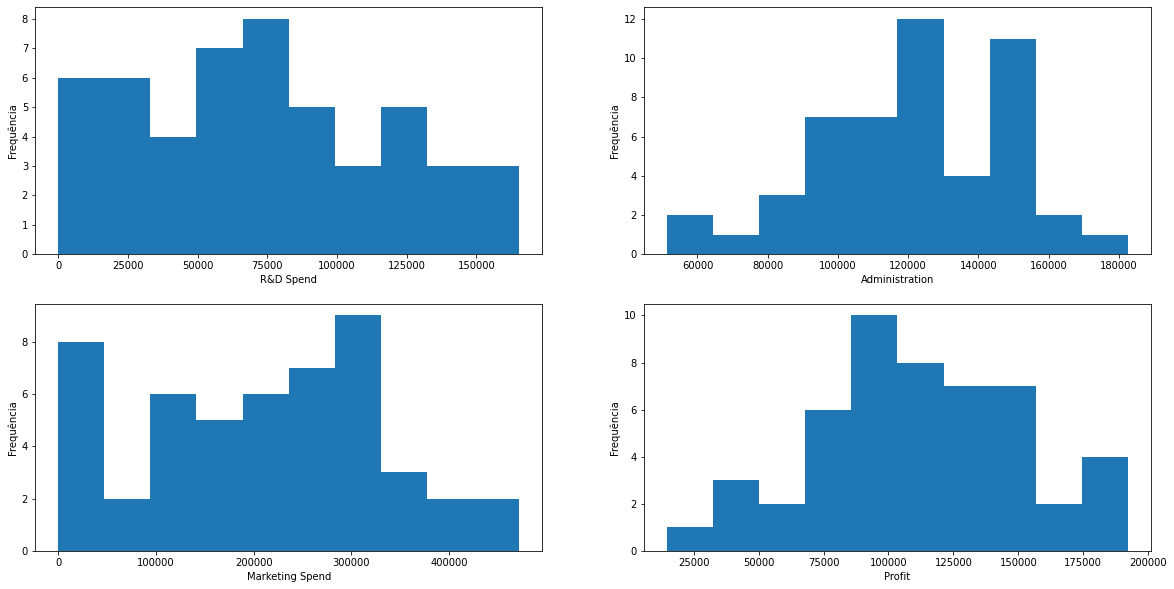

In [42]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

counter = 0 

for i in range(nrows): # para cada linha
  for j in range(ncols): # plotar o número de colunas

    ax = axes[i][j]
    
    print(i,j) #Só para ver os valores da linha e coluna.

    # Plotar somente quando houver dados
    if counter < len(contColNames):

      ax.hist(df.select_dtypes(include='number')[contColNames[counter]], bins=10)
      ax.set_xlabel(contColNames[counter])
      ax.set_ylabel('Frequência')

    else:
      ax.set_axis_off()

    counter += 1

plt.show()

### 2.2.4 Plotar o gráfico de barras

Text(0.5, 1.0, 'Distribuição dos estados')

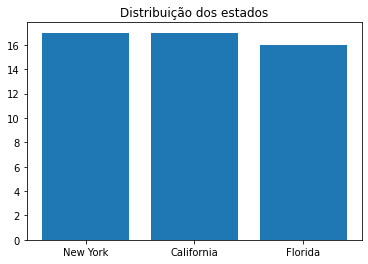

In [45]:
fig = plt.figure()

plt.bar(df['State'].unique(), df['State'].value_counts())

plt.title('Distribuição dos estados', loc='center')

### 2.2.5 Plotar gráfico de correlação

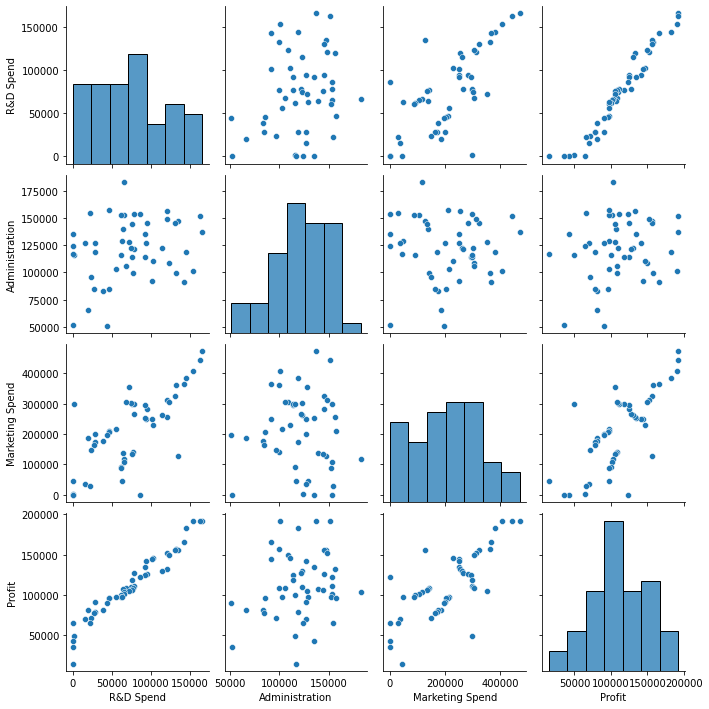

In [ ]:
sns.pairplot(df)
# Nota-se grande correlação entre o gasto em pesquisa e desenvolvimento com o lucro.
# Também temos certa correlação entre marketing e lucro e possível correlação entre marketing e pesquisa e desenvolvimento.

### 2.2.6 Plotar o box-plot

<AxesSubplot:xlabel='State', ylabel='Profit'>

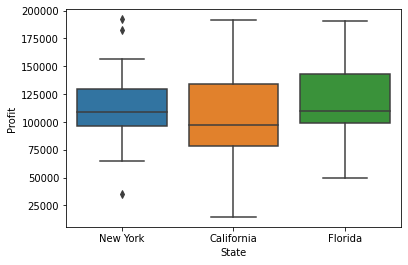

In [46]:
sns.boxplot(x=df['State'],y=df['Profit'])
# Fazendo o gráfico sem montar a figura o matplotlib.

Text(0, 0.5, '')

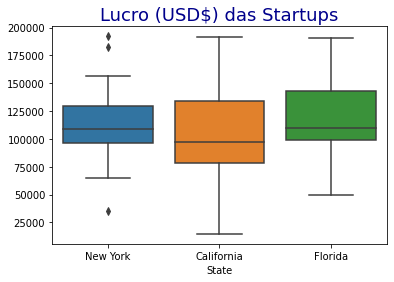

In [55]:
fig = plt.figure()

sns.boxplot(x = df['State'], y = df['Profit'])

plt.title('Lucro (USD$) das Startups', fontsize = 18, fontweight = 18, loc = 'center',color='darkblue')

plt.ylabel('')
# Fazendo a figura do matplot, conseguimos colocar títulos etc.

# 3 PRÉ-PROCESSAMENTO DOS DADOS

## 3.1 Separar as variáveis

### 3.1.1 Variáveis contínuas

In [56]:
dfNum = df.select_dtypes(include='number').drop(['Profit'], axis = 1)
# Axis serve para falar que tem que dropar colunas ou linhas.

In [57]:
dfNum.head()

,R&D Spend,Administration,Marketing Spend
0,165349.20,136897.80,471784.10
1,162597.70,151377.59,443898.53
2,153441.51,101145.55,407934.54
3,144372.41,118671.85,383199.62
4,142107.34,91391.77,366168.42


### 3.1.2 Variáveis categoricas

In [63]:
# Mudar o tipo de variável para 'categórico', pois se não o python não entende como variável categórica e sim como object.
df['State'] = df['State'].astype('category')

# Selecionar somente as variáveis categóricas
dfCat = df.select_dtypes(include='category')

In [64]:
dfCat.head()

,State
0,New York
1,California
2,Florida
3,New York
4,Florida


In [73]:
dfCat.value_counts()

State     
California    17
New York      17
Florida       16
dtype: int64

### 3.1.3 Resposta

In [67]:
y = df['Profit']
y.head()

0    192261.83
1    191792.06
2    191050.39
3    182901.99
4    166187.94
Name: Profit, dtype: float64

## 3.2 Pré-tratamento da resposta


### 3.2.1 Teste resposta original

![title](fig1.png)

In [77]:
kStat, kPvalue = sp.stats.kstest(rvs=y, cdf='norm')
# Essa função salva 2 informações, a estatistica de teste e o P value, para sabermos se estamos perto de uma distribuição normal.

In [75]:
kStat
# Quanto maior o KStat, menos normal a distribuição é.

1.0

In [76]:
kPvalue

0.0

### 3.2.3 Teste log da resposta

In [104]:
kStat, kPvalue = sp.stats.kstest(rvs=np.log(y), cdf='norm')

<AxesSubplot:>

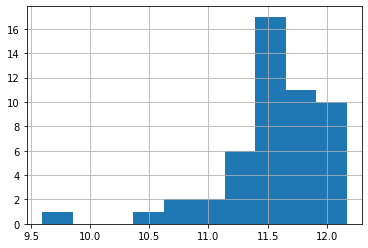

In [96]:
y2=np.log(y)
y2.hist()

In [97]:
kStat

1.0

In [98]:
kPvalue

0.0

(array([ 1.,  0.,  0.,  1.,  2.,  2.,  6., 17., 11., 10.]),
 array([ 9.59433667,  9.85156434, 10.10879202, 10.36601969, 10.62324737,
        10.88047504, 11.13770272, 11.39493039, 11.65215807, 11.90938574,
        12.16661342]),
 <BarContainer object of 10 artists>)

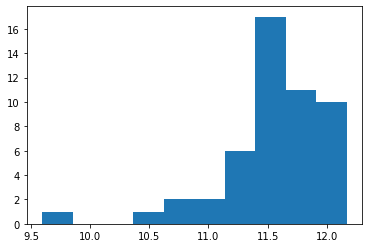

In [99]:
fig = plt.figure()
plt.hist(np.log(y))

In [100]:
kStat, kPvalue = sp.stats.kstest(rvs=1/y, cdf='norm')

## 3.3 Pré-tratamento das vaiáveis contínuas

In [123]:
print(np.mean(dfNum))
print('\n',np.std(dfNum))

R&D Spend           73721.6156
Administration     121344.6396
Marketing Spend    211025.0978
dtype: float64

 R&D Spend           45440.915563
Administration      27736.209651
Marketing Spend    121061.231183
dtype: float64


In [124]:
# Criar a função para o escalonamento dos dados
def feat_scale(X):

  # Calcular a média de todas as variáveis
  mu = np.mean(X, axis = 0)

  # Calcular o devio padrão de todas as variáveis (ddof=1 é para calcular o desvio padrão amostral)
  sigma = np.std(X, axis=0, ddof=1)

  # Fazer o escalonamento das variáveis
  xNorm = (X - mu)/sigma

  return xNorm

In [125]:
dfNorm = feat_scale(dfNum)

In [126]:
dfNorm.head()

,R&D Spend,Administration,Marketing Spend
0,1.996146,0.555117,2.132295
1,1.936203,1.071924,1.904267
2,1.736731,-0.720938,1.610180
3,1.539157,-0.095396,1.407916
4,1.489812,-1.069066,1.268648


In [130]:
dfNorm.reset_index(drop=True).head()

,R&D Spend,Administration,Marketing Spend
0,1.996146,0.555117,2.132295
1,1.936203,1.071924,1.904267
2,1.736731,-0.720938,1.610180
3,1.539157,-0.095396,1.407916
4,1.489812,-1.069066,1.268648


## 3.4 Pré-tratamento das variáveis categóricas

In [127]:
dfDum = pd.get_dummies(dfCat)

In [128]:
dfDum.head()

,State_California,State_Florida,State_New York
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,0,1,0


In [131]:
dfFinal = pd.concat([dfNorm.reset_index(drop=True), dfDum], axis=1)

In [132]:
dfFinal.head()

,R&D Spend,Administration,Marketing Spend,State_California,State_Florida,State_New York
0,1.996146,0.555117,2.132295,0,0,1
1,1.936203,1.071924,1.904267,1,0,0
2,1.736731,-0.720938,1.610180,0,1,0
3,1.539157,-0.095396,1.407916,0,0,1
4,1.489812,-1.069066,1.268648,0,1,0


# 4 AJUSTE DO MODELO DE REGRESSÃO

1. Crie a matriz do modelo utilizando o método dos mínimos 
quadrados;<br><br>
2. Ajuste os nomes das colunas;<br>
● Ajuste o Dataset para desenvolver o modelo;<br><br>
3. Construa a fórmula de regressão:<br>
● Listar o nome das colunas do dataframe<br>
● Remover a variável dependente;<br>
● Remover as variáveis excluídas;<br>
● Retornar a fórmula.<br><br>
4. Ajuste a Matriz do modelo

## 4.1 Método dos mínimos quadrados

### 4.1.1 Adição da resposta e alteração dos nomes das colunas

In [141]:
y.name

'Profit'

In [138]:
y.head()

0    192261.83
1    191792.06
2    191050.39
3    182901.99
4    166187.94
Name: Profit, dtype: float64

In [134]:
# Adição das respostas (profit)
dfFull = pd.concat([y, dfFinal], axis = 1)
dfFull.head()

,Profit,R&D Spend,Administration,Marketing Spend,State_California,State_Florida,State_New York
0,192261.83,1.996146,0.555117,2.132295,0,0,1
1,191792.06,1.936203,1.071924,1.904267,1,0,0
2,191050.39,1.736731,-0.720938,1.610180,0,1,0
3,182901.99,1.539157,-0.095396,1.407916,0,0,1
4,166187.94,1.489812,-1.069066,1.268648,0,1,0


In [143]:
# Alterar nome das colunas
dfFull.rename(columns={'R&D Spend':'rd',
                       'Administration':'adm',
                       'Marketing Spend':'mkt',
                       'State_California':'ca',
                       'State_Florida':'fl',
                       'State_New York':'ny'},
              inplace = True
)
dfFull.head(1)

,Profit,rd,adm,mkt,ca,fl,ny
0,192261.83,1.996146,0.555117,2.132295,0,0,1


### 4.1.2 Função para escrever a fórmula


In [169]:
x=dfFull.columns.values
x

array(['Profit', 'rd', 'adm', 'mkt', 'ca', 'fl', 'ny'], dtype=object)

In [168]:
def ols_formula(df, dependent_var, *excluded_rows):

  # Listar o nome das colunas do dataframe
  dfCols = list(df.columns.values)

  # Remover a variável dependente
  dfCols.remove(dependent_var)

  # Remover as variáveis excluídas
  for col in excluded_rows:
    dfCols.remove(col)

  # Retornar a fórmula
  return dependent_var + ' ~ ' + ' +'.join(dfCols)
  

### 4.1.3 Matrix do modelo

In [170]:
ols_formula(dfFull, 'Profit')

'Profit ~ rd +adm +mkt +ca +fl +ny'

In [171]:
y, X = pt.dmatrices(ols_formula(dfFull, 'Profit'), data = dfFull , return_type='dataframe')

In [174]:
y.head()

,Profit
0,192261.83
1,191792.06
2,191050.39
3,182901.99
4,166187.94


In [173]:
X.head() #Adicionou o intercept, onde cruza em y quando x=0

,Intercept,rd,adm,mkt,ca,fl,ny
0,1.0,1.996146,0.555117,2.132295,0.0,0.0,1.0
1,1.0,1.936203,1.071924,1.904267,1.0,0.0,0.0
2,1.0,1.736731,-0.720938,1.610180,0.0,1.0,0.0
3,1.0,1.539157,-0.095396,1.407916,0.0,0.0,1.0
4,1.0,1.489812,-1.069066,1.268648,0.0,1.0,0.0


### 4.1.3 Ajuste do modelo

In [175]:
# Especificação do modelo
reg1 = sm.OLS(y, X)

# Executa o método dos mínimos quadrados
reg1fit = reg1.fit()

In [182]:
print(reg1fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Mon, 23 May 2022   Prob (F-statistic):           1.34e-27
Time:                        21:01:46   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.401e+04   1001.609     83.877      0.0

## 4.2 Método do Gradiente descendente

1. Crie a matriz do modelo utilizando o método do gradiente 
descendente;<br><br>
2. Construa a Função Perda;<br>
● Previsão da resposta;<br>
● Calcular os erros de previsão;<br>
● Calcular o quadrado dos erros;<br>
● Calcular a perda;<br><br>
3. Construa a função gradiente descendente;<br><br>
4. Aplicação do algoritmo de Gradiente Descendente;<br>
● Configure o algoritmo;<br>
● Aplique o algoritmo;<br>
● Estude a convergência;<br>

### 4.2.1 Função perda

In [184]:
def funcao_perda(X, y, beta):

  """
  X é a matriz com os regressores (m x n).
  y é a série com a resposta (1, m).
  beta é a série dos parâmetros (1 x n).
  """

  # Previsão da resposta
  pred = X.dot(beta)

  # Calcular os erros de previsão
  res = np.subtract(pred, y.squeeze()) #Resultado daqui é uma série

  # Calcular o quadrado dos erros
  sqrRes = np.square(res) #Resultado daqui é uma série

  # Calcular a perda
  perda = 1/(2*m) * np.sum(sqrRes) #Resultado daqui é um valor

  return perda

### 4.2.2 Função gradiente descendente

In [187]:
def grad_des(X, y, beta, alpha, itera):

  """
  X é a matriz dos regressores (m x n).
  y é a série da resposta (1 x m).
  beta é a série dos valores iniciais dos parâmetros (1 x n).
  alpha é a taxa de aprendizagem (escalar).
  itera é o número de iterações do algoritmo.

  __________________________________________
  Resultados

  beta é a série com os valores finais dos parâmetros.
  hperda é a série histórica das perdas.

  """

  # Inicializa a série do histórico de perdas
  hPerda = np.zeros(itera)

  for i in range(itera):

    # Calcula as previsões com os valores atuais dos parâmetros
    pred = X.dot(beta)

    # Calcula os resíduos da previsão
    res = np.subtract(pred, y.squeeze())

    # Calcula o incremento / decremento valor dos betas - derivada parcial da função perda
    sumDelta = (alpha / m) * X.transpose().dot(res)

    # Atualizar o varlos dos betas do modelo
    beta = beta - sumDelta

    #Calcula a nova perda com os novos valores dos betas
    hPerda[i] = funcao_perda(X, y, beta)

  return beta, hPerda


### 4.2.3 Aplicação do algoritmo de gradiente descendente

In [192]:
X.head(3)

,Intercept,rd,adm,mkt,ca,fl,ny
0,1.0,1.996146,0.555117,2.132295,0.0,0.0,1.0
1,1.0,1.936203,1.071924,1.904267,1.0,0.0,0.0
2,1.0,1.736731,-0.720938,1.610180,0.0,1.0,0.0


In [195]:
X.shape

(50, 7)

In [189]:
y.head(3)

,Profit
0,192261.83
1,191792.06
2,191050.39


#### Configuração do algoritmo

In [228]:
# Salvar o tamanho do df com os regressores (incluindo o intercept)
m, n = X.shape #Lembrando que X não tem a resposta (Profit)
# m= linhas e n = colunas

# Inicializa a série de betas
beta = np.zeros(n)

# Iterações
itera = 1000

# Taxa de aprendizagem
alpha = 0.3

In [206]:
print(m,',',n)
print('Beta: ',beta,'\n','Itera: ', itera,'\n','Alpha: ',alpha)

50 , 7
Beta:  [0. 0. 0. 0. 0. 0. 0.] 
 Itera:  1000 
 Alpha:  0.3


#### Aplicação do algoritmo

In [229]:
beta, hPerda = grad_des(X = X, y = y, beta = beta, alpha = alpha, itera = itera)

In [230]:
beta

Intercept    84011.676723
rd           36998.279697
adm           -756.601699
mkt           3299.375589
ca           27951.591650
fl           28150.380443
ny           27909.704631
dtype: float64

In [214]:
hPerda

array([2.51480970e+09, 9.38368455e+08, 3.82761273e+08, 1.83162896e+08,
       1.09381086e+08, 8.06177446e+07, 6.82285032e+07, 6.19727188e+07,
       5.81533157e+07, 5.54136659e+07, 5.32393862e+07, 5.14220000e+07,
       4.98661620e+07, 4.85199923e+07, 4.73496439e+07, 4.63298177e+07,
       4.54400595e+07, 4.46631796e+07, 4.39844732e+07, 4.33912578e+07,
       4.28725530e+07, 4.24188315e+07, 4.20218166e+07, 4.16743107e+07,
       4.13700503e+07, 4.11035805e+07, 4.08701478e+07, 4.06656075e+07,
       4.04863439e+07, 4.03292009e+07, 4.01914225e+07, 4.00706009e+07,
       3.99646315e+07, 3.98716744e+07, 3.97901200e+07, 3.97185602e+07,
       3.96557622e+07, 3.96006471e+07, 3.95522696e+07, 3.95098021e+07,
       3.94725190e+07, 3.94397847e+07, 3.94110419e+07, 3.93858021e+07,
       3.93636369e+07, 3.93441705e+07, 3.93270733e+07, 3.93120561e+07,
       3.92988652e+07, 3.92872781e+07, 3.92770992e+07, 3.92681570e+07,
       3.92603011e+07, 3.92533992e+07, 3.92473352e+07, 3.92420074e+07,
      

In [216]:
range(1, itera + 1)

range(1, 1001)

Text(0.5, 1.0, 'Histórico de perdas')

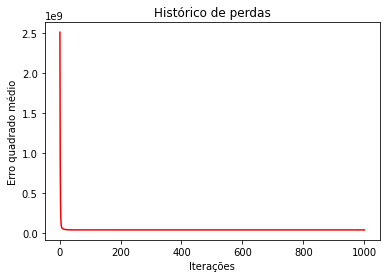

In [231]:
# Estudo de convergência

fig = plt.figure()

plt.plot(range(1, itera + 1), hPerda, color = 'red')

plt.xlabel('Iterações')

plt.ylabel('Erro quadrado médio')

plt.title('Histórico de perdas', loc = 'center')

# 5 SIGNIFICÂNCIA ESTATÍSTICA

● Crie um sumário e analise os dados de significância estatística do modelo; <br>
● Reajuste do modelo e criação de matriz;<br>
● Reajuste o sumério e traga as informações fundamentais a serem analisadas

## 5.1 Recap sumário do modelo

In [232]:
print(reg1fit.summary())
# "F-statistic" é o valor de F, quanto maior, mais significativo o modelo (lembrando que o F nos diz sobre o MODELO como um todo,
# não sobre os fatores independentes.)
# "Prob (F-statistic) é nosso p-value, quanto menor este valor mais significativo o modelo é."
# Cada "coef" é um beta, começando em beta0 (intercept).
# Quanto maior o "t", mais significativa é aquele coeficiente.
# Quanto menor o p-value ("P>|t|"), MAIS significativo é o coeficiente.

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Tue, 24 May 2022   Prob (F-statistic):           1.34e-27
Time:                        13:22:36   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.401e+04   1001.609     83.877      0.0

## 5.2 Reajuste do modelo (modelo reduzido)

### 5.2.1 Nova matrix do modelo

In [ ]:
def ols_formula(df, dependent_var, *excluded_rows):

  # Listar o nome das colunas do dataframe
  dfCols = list(df.columns.values)

  # Remover a variável dependente
  dfCols.remove(dependent_var)

  # Remover as variáveis excluídas
  for col in excluded_rows:
    dfCols.remove(col)

  # Retornar a fórmula
  return dependent_var + ' ~ ' + ' +'.join(dfCols)

In [243]:
ols_formula(dfFull, 'Profit', 'adm') 
# Aqui tiramos a coluna adm como uma coluna para ser excluida, pois vimos que esse termo não é significativo.

'Profit ~ rd +mkt +ca +fl +ny'

In [244]:
y, Xred = pt.dmatrices(ols_formula(dfFull, 'Profit', 'adm'), data = dfFull , return_type='dataframe')

In [245]:
Xred.head(1)

,Intercept,rd,mkt,ca,fl,ny
0,1.0,1.996146,2.132295,0.0,0.0,1.0


In [246]:
# Especificação do modelo
reg2 = sm.OLS(y, Xred)

# Executa o método dos mínimos quadrados
reg2fit = reg2.fit()

In [247]:
print(reg2fit.summary())
# Interessante notar que o F aumentou, ou seja, o modelo ficou mais significativo.
# Os valores referentes ao mkt também mudaram, mesmo temos somente tirado a variável adm,
# isso aconteceu pois existe uma multicolinearidade.

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     215.8
Date:                Wed, 25 May 2022   Prob (F-statistic):           9.72e-29
Time:                        04:02:58   Log-Likelihood:                -525.53
No. Observations:                  50   AIC:                             1061.
Df Residuals:                      45   BIC:                             1071.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.401e+04    993.420     84.567      0.0

# 6 QUALIDADE DE AJUSTE

## 6.1 Separar os datasets

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [ ]:
xTrain.reset_index(drop=True, inplace=True)
xTest.reset_index(drop=True, inplace=True)
yTrain.reset_index(drop=True, inplace=True)
yTest.reset_index(drop=True, inplace=True)

## 6.2 Ajuste do modelo - mínimos quadrados

### 6.2.1 Modelo 'full'

In [ ]:
reg3 = sm.OLS(yTrain, xTrain)
reg3fit = reg3.fit()

In [ ]:
print(reg3fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     145.1
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           4.15e-24
Time:                        22:26:01   Log-Likelihood:                -473.01
No. Observations:                  45   AIC:                             958.0
Df Residuals:                      39   BIC:                             968.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.333e+04   1082.962     76.948      0.0

### 6.2.2 Modelo 'reduzido' 

In [ ]:
xTrainRed = xTrain.drop(['adm'], axis = 1)

In [ ]:
reg4 = sm.OLS(yTrain, xTrainRed.drop(['ca'], axis=1))
reg4fit = reg4.fit()

In [ ]:
print(reg4fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     186.0
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           2.85e-25
Time:                        22:41:21   Log-Likelihood:                -473.01
No. Observations:                  45   AIC:                             956.0
Df Residuals:                      40   BIC:                             965.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.112e+05   2390.740     46.533      0.0

## 6.3 Avaliação de multicolinearidade

In [ ]:
pd.DataFrame({'Variaveis': xTrainRed.columns[1:],
              'VIF': [variance_inflation_factor(xTrainRed.values, i+1) for i in range(len(xTrainRed.columns[1:]))]})

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variaveis,VIF
0,rd,2.055984
1,mkt,2.126109
2,ca,inf
3,fl,inf
4,ny,inf


## 6.4 Qualidade de ajuste (Mínimos Quadrados)

In [ ]:
predY = pd.concat([yTest, reg4fit.predict(xTest.drop('adm', axis = 1))], axis = 1)

In [ ]:
predY.columns = ['profReal', 'profPred']
predY

,profReal,profPred
0,103282.38,101173.929112
1,144259.40,133503.979045
2,146121.95,132672.287753
3,77798.83,72860.882041
4,191050.39,178540.806994


In [ ]:
print('Rquadrado', metrics.r2_score(predY['profReal'], predY['profPred']))

Rquadrado 0.9365755604263571


In [ ]:
print('Raiz do erro quadrado médio', 
      np.sqrt(metrics.mean_squared_error(predY['profReal'], predY['profPred'])))

Raiz do erro quadrado médio 9817.24051507419


## 6.5 Qualidade de ajuste (Gradiente descendente)

### 6.5.1 Ajuste do modelo reduzido

In [ ]:
# Salvar o tamanho do df com os regressores (incluindo o intercept)
m, n = xTrainRed.shape

# Inicializa a série de betas
beta = np.zeros(n)

In [ ]:
beta, hPerda = grad_des(X = xTrainRed , y = yTrain, beta = beta, alpha = alpha, itera = itera)

### 6.5.2 Criar matrix com previões

In [ ]:
predGradY = pd.concat([yTest, xTest.drop('adm', axis=1).dot(beta)], axis = 1)

In [ ]:
predGradY

,Profit,0
0,103282.38,101173.929112
1,144259.40,133503.979045
2,146121.95,132672.287753
3,77798.83,72860.882041
4,191050.39,178540.806994


In [ ]:
predGradY.columns = ['profReal', 'profPred']

### 6.5.3 Métricas de qualidade

In [ ]:
print('Rquadrado', metrics.r2_score(predGradY['profReal'], predGradY['profPred']))
print('Raiz do erro quadrado médio', 
      np.sqrt(metrics.mean_squared_error(predGradY['profReal'], predGradY['profPred'])))

Rquadrado 0.9365755604263568
Raiz do erro quadrado médio 9817.24051507422


# 7 ANÁLISE DE RESÍDUOS

## 7.1 Calculo dos Resíduos

In [ ]:
# Gerar previsões
predY = pd.concat([yTrain, reg4fit.predict(xTrainRed)], axis = 1)

In [ ]:
predY.columns = ['profReal', 'profPred']

In [ ]:
predY['Res'] = predY['profReal'] - predY['profPred']

In [ ]:
predY.head()

,profReal,profPred,Res
0,105008.31,115244.039573,-10235.729573
1,81229.06,69446.146726,11782.913274
2,97483.56,98298.998430,-815.438430
3,110352.25,113231.200990,-2878.950990
4,166187.94,168374.289616,-2186.349616


## 7.2 Distribuição dos resíduos

(array([ 1.,  0.,  0.,  2.,  2.,  6., 16.,  8.,  6.,  4.]),
 array([-33786.66537421, -28779.23009423, -23771.79481424, -18764.35953425,
        -13756.92425427,  -8749.48897428,  -3742.05369429,   1265.3815857 ,
          6272.81686568,  11280.25214567,  16287.68742566]),
 <a list of 10 Patch objects>)

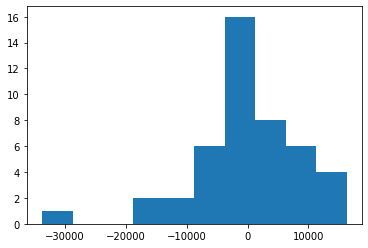

In [ ]:
fig = plt.figure()
plt.hist(predY['Res'])

In [ ]:
kStat, kPvalue = sp.stats.kstest(predY['Res'], 'norm')

In [ ]:
kStat

0.5111111111111111

In [ ]:
kPvalue

1.9730177301725436e-11

In [ ]:
# Ajuste do modelo com Log da resposta
reg5 = sm.OLS(np.log(yTrain), xTrainRed)
reg5fit = reg5.fit()

In [ ]:
# Cálculo dos resíduos
predLogY = pd.concat([np.log(yTrain), reg5fit.predict(xTrainRed)], axis = 1)

predLogY.columns = ['profLogReal', 'profLogPred']

predLogY['LogRes'] = predLogY['profLogReal'] - predLogY['profLogPred']

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  9., 16., 18.]),
 array([-1.25037585, -1.10267465, -0.95497345, -0.80727225, -0.65957105,
        -0.51186985, -0.36416865, -0.21646744, -0.06876624,  0.07893496,
         0.22663616]),
 <a list of 10 Patch objects>)

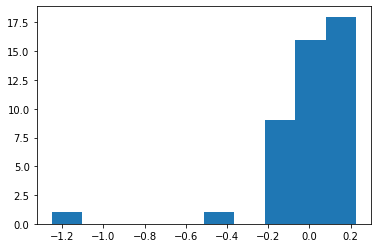

In [ ]:
fig = plt.figure()
plt.hist(predLogY['LogRes'])

In [ ]:
kStat, kPvalue = sp.stats.kstest(predLogY['LogRes'], 'norm')

In [ ]:
kStat

0.4103533362594217

In [ ]:
kPvalue

2.285315188032897e-07

## 7.3 Homocedasticidade

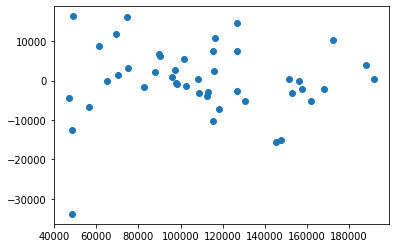

In [ ]:
fig = plt.figure()
plt.scatter(predY['profPred'], predY['Res'])

# 8 REGRESSÃO REGULARIZADA

In [ ]:
# Especificar o modelo
regRidge = Ridge(alpha=0.1)

In [ ]:
regRidge.fit(xTrain.drop(['Intercept', 'ca'], axis=1), yTrain)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
print(regRidge.coef_)

[[35547.43545277   214.93479161  4047.11894302 -1148.90169109
    806.98268321]]


In [ ]:
print(regRidge.intercept_)

[111215.66068219]


In [ ]:
# Prever valores para o dataset de testex
predYReg = pd.concat([yTest, pd.DataFrame(regRidge.predict(xTest.drop(['Intercept', 'ca'], axis = 1)))], axis = 1)

In [ ]:
predYReg

,Profit,0
0,103282.38,101523.476025
1,144259.40,133141.110375
2,146121.95,132416.399246
3,77798.83,72754.571035
4,191050.39,178164.745985


In [ ]:
predYReg.columns = ['Profit', 'predProfit']

In [ ]:
print('Rquadrado', metrics.r2_score(predYReg['Profit'], predYReg['predProfit']))
print('Raiz do erro quadrado médio', 
      np.sqrt(metrics.mean_squared_error(predYReg['Profit'], predYReg['predProfit'])))

Rquadrado 0.9333976274210263
Raiz do erro quadrado médio 10060.184879396556
